# Example of how to use the environment

In [1]:
!pip install -q matplotlib numpy scipy

from environment import truly_dynamic_environment, replay, visualize, HelperFunctions
import numpy as np


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\hiren\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Define agent functions. One example used a simple function and the second uses a class which should be used for model-based agents.

In [2]:
import random

class PureMonteCarloAgent:
    def __init__(self, simulations_per_action=500):
        self.simulations_per_action = simulations_per_action

    def random_playout(self, board, player):
        current_player = player
        while HelperFunctions.check_win(board) is None:  # Use the provided win-checking function
            valid_actions = HelperFunctions.get_valid_moves(board)  # Get valid moves
            if not valid_actions:
                break  # If no valid moves, it's a draw
            action = random.choice(valid_actions)
            board = HelperFunctions.place(action, board, current_player)  # Place the piece
            current_player = -current_player  # Switch player
        return HelperFunctions.check_win(board)  # Return the game result

    def monte_carlo_agent(self, board, player=1):
        valid_actions = HelperFunctions.get_valid_moves(board)  # Get valid moves
        action_scores = {action: 0 for action in valid_actions}

        # Perform simulations for each action
        for action in valid_actions:
            wins = 0
            for _ in range(self.simulations_per_action):
                simulated_board = HelperFunctions.place(action, board.copy(), player)  # Simulate the move
                result_outcome = self.random_playout(simulated_board, -player)
                if result_outcome == player:
                    wins += 1
            action_scores[action] = wins

        # Select the action with the highest win rate
        best_action = max(action_scores, key=action_scores.get)
        return best_action

    def __call__(self, board, player):
        return self.monte_carlo_agent(board, player)

In [3]:
class MonteWithWinDetection:
    def __init__(self, simulations_per_action=2000):
        self.simulations_per_action = simulations_per_action

    def check_immediate_win(self, board, player):
        valid_actions = HelperFunctions.get_valid_moves(board)
        for action in valid_actions:
            simulated_board = HelperFunctions.place(action, board.copy(), player)
            if HelperFunctions.check_win(simulated_board) == player:
                return action  # Immediate win found
        return None

    def check_immediate_loss(self, board, player):
        opponent = -player
        valid_actions = HelperFunctions.get_valid_moves(board)
        for action in valid_actions:
            simulated_board = HelperFunctions.place(action, board.copy(), opponent)
            if HelperFunctions.check_win(simulated_board) == opponent:
                return action  # Immediate loss found (opponent win)
        return None

    def monte_carlo_agent(self, board, player=1):
        # Step 1: Check for immediate win
        immediate_win = self.check_immediate_win(board, player)
        if immediate_win is not None:
            return immediate_win

        # Step 2: Check for opponent's immediate win and block it
        immediate_loss = self.check_immediate_loss(board, player)
        if immediate_loss is not None:
            return immediate_loss

        # Step 3: Monte Carlo simulations if no immediate win/loss detected
        valid_actions = HelperFunctions.get_valid_moves(board)
        action_scores = {action: 0 for action in valid_actions}

        for action in valid_actions:
            wins = 0
            for _ in range(self.simulations_per_action):
                simulated_board = HelperFunctions.place(action, board.copy(), player)
                result_outcome = self.random_playout(simulated_board, -player)
                if result_outcome == player:
                    wins += 1
            action_scores[action] = wins

        # Step 4: Choose the best action based on win rate
        best_action = max(action_scores, key=action_scores.get)
        return best_action

    def random_playout(self, board, player):
        current_player = player
        while HelperFunctions.check_win(board) is None:
            valid_actions = HelperFunctions.get_valid_moves(board)
            if not valid_actions:
                break
            action = random.choice(valid_actions)
            board = HelperFunctions.place(action, board, current_player)
            current_player = -current_player
        return HelperFunctions.check_win(board)

    def __call__(self, board, player):
        return self.monte_carlo_agent(board, player)

In [4]:
import math

import copy
def actions(state):
  actionList = []
  for i in range(len(state[0])):
    if state[0][i] == 0:
      actionList.append(i)
  return actionList

def result(state, player, action):
  board = copy.deepcopy(state)
  if board[len(state) - 1][action] == 0:
      board[len(state) - 1][action] = player
  else:
    for i in range(len(board)):
      if board[i][action] != 0:
        board[i - 1][action] = player
        break
  return board

def terminal(state):
  def checkLine(row, column, dRow, dColumn):
    player = state[row][column]
    if player == 0:
      return False
    for i in range(1, 4):
      nRow, nColumn = row + i * dColumn, column + i * dRow
      if nRow < 0 or nRow >= len(state) or nColumn < 0 or nColumn >= len(state[0]) or state[nRow][nColumn] != player:
        return False
    return True

  for r in range(len(state)):
    for c in range(len(state[0])):
      if (checkLine(r, c, 0, 1) or checkLine(r, c, 1, 0)
      or checkLine(r, c, 1, 1) or checkLine(r, c, 1, -1)):
        return True

  for row in state:
    if 0 in row:
      return False

  return True

def utility(s, player):
  def checkLine(row, column, dRow, dColumn):
    checkPlayer = s[row][column]
    if checkPlayer != player:
      return False
    for i in range(1, 4):
      nRow, nColumn = row + i * dColumn, column + i * dRow
      if nRow < 0 or nRow >= len(s) or nColumn < 0 or nColumn >= len(s[0]) or s[nRow][nColumn] != player:
        return False
    return True

  for r in range(len(s)):
    for c in range(len(s[0])):
      if (checkLine(r, c, 0, 1) or checkLine(r, c, 1, 0)
      or checkLine(r, c, 1, 1) or checkLine(r, c, 1, -1)):
        return +1

  for row in s:
    if 0 in row:
      return -1

  return 0

def calc_heuristic2(state, player):
  score = 0
  center_column = len(state[0]) // 2

  def evaluate_window(window, target_player):
    score = 0
    count_player = window.count(target_player)
    count_empty = window.count(0)

    if count_player == 4:
        score += 100  # Win
    elif count_player == 3 and count_empty == 1:
        score += 10  # Strong threat
    elif count_player == 2 and count_empty == 2:
        score += 5  # Good setup

    return score

  # Horizontal, vertical, diagonal checks
  for r in range(len(state)):
      for c in range(len(state[0]) - 3):  # Horizontal
          window = [state[r][c+i] for i in range(4)]
          score += evaluate_window(window, player)

  for r in range(len(state) - 3):
      for c in range(len(state[0])):  # Vertical
          window = [state[r+i][c] for i in range(4)]
          score += evaluate_window(window, player)

  for r in range(len(state) - 3):
      for c in range(len(state[0]) - 3):  # Positive diagonal
          window = [state[r+i][c+i] for i in range(4)]
          score += evaluate_window(window, player)

      for c in range(3, len(state[0])):  # Negative diagonal
          window = [state[r+i][c-i] for i in range(4)]
          score += evaluate_window(window, player)

  # Center column bonus
  center_count = sum([row[center_column] == player for row in state])
  score += center_count * 3  # Center control is strategic

  return score

def order_moves(board, actions, player):
  scored_moves = []
  for a in actions:
      new_board = result(board, player, a)
      heuristic_value = calc_heuristic2(new_board, player)
      scored_moves.append((a, heuristic_value))
  # Sort moves based on heuristic value (descending)
  scored_moves.sort(key=lambda x: x[1], reverse=True)
  return [move[0] for move in scored_moves]

## global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

class improvedMMSHeuristicAgent:
  def __init__(self, maxDepth = 4):
    self.maxDepth = maxDepth

  def alpha_beta_search(self, board, player = 1):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    player = player * -1

    value, move = self.max_value_ab(board, player, -math.inf, +math.inf)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return move

  def max_value_ab(self, state, player, alpha, beta, depth = 0):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    if(terminal(state)):
      v = utility(state, player)
      if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
      if v is not None:
          if DEBUG >= 2: print(f"     found terminal state. backtracking.")
          return v, None

    if depth == self.maxDepth:
      return calc_heuristic2(state, player), None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in order_moves(state, actions(state), player):
        v2, a2 = self.min_value_ab(result(state, player, a), player, alpha, beta, depth + 1)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

  def min_value_ab(self, state, player, alpha, beta, depth = 0):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    if(terminal(state)):
      v = utility(state, player)
      if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
      if v is not None:
          if DEBUG >= 2: print(f"     found terminal state. backtacking.")
          return v, None

    if depth == self.maxDepth:
      return calc_heuristic2(state, player), None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in order_moves(state, actions(state), player):
        v2, a2 = self.max_value_ab(result(state, player * -1, a), player, alpha, beta, depth + 1)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move


Create an instance of the class-based agent and create the configuration list for the environment.

In [5]:
monteagent = MonteWithWinDetection(simulations_per_action=7000)
heuristicagent = improvedMMSHeuristicAgent(8)
players = [
    {
        "algo": heuristicagent.alpha_beta_search,
        "name": "Ethan's Agent",
        "player": +1,
        "args": {}
    },
    {
        "algo": monteagent,
        "name": "Hiren's Agent",
        "player": -1,
        "args": {}
    }
]

Run the game

Ethan's Agent took a total of 54.579 seconds
Hiren's Agent took a total of 206.534 seconds
The winner is Hiren's Agent (-1)
Turns Taken: 22


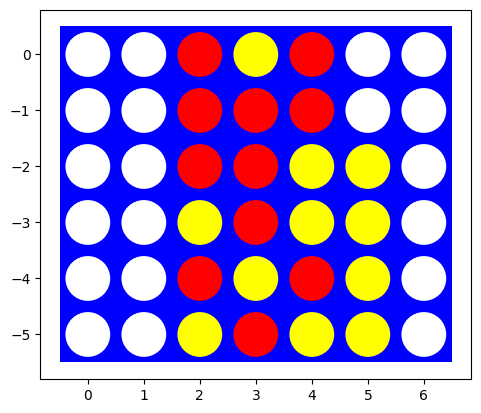

In [6]:

result,final_board,all_boards = truly_dynamic_environment(players, size=(6,7), visual = True)

visualize(final_board)

Slow a replay for analysis.

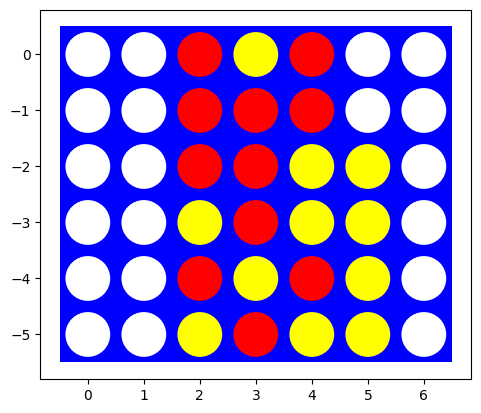

In [7]:
replay(all_boards)